# Benchmarks 6-Body Solar System (constant step size)

## Loading packages and functions

In [1]:
using LinearAlgebra, Plots
using OrdinaryDiffEq
using NbodyIRKGL16

[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]
[ Info: Precompiling SpecialFunctionsExt [997ecda8-951a-5f50-90ea-61382e97704b]
[ Info: Precompiling SparseMatrixColoringsColorsExt [42e6ba4b-6785-530d-add2-80af3b5b757b]


In [2]:
#to install NbodyIRKGL16.jl package
# using Pkg
# Pkg.add(url="https://github.com/mikelehu/NbodyIRKGL16.jl") 


#Local version
#PATH_SRC="../src/"
#include(string(PATH_SRC,"NbodyIRKGL16.jl"))
#using .NbodyIRKGL16 

### Some aux functions

In [3]:
function run_many_NbodyIRKGL(ddt0, tspan,u0, parms, HAM;simdB=true, adaptiveB=true)

    nruns=1
    
    u0_B=BigFloat.(u0)
    Gm_B=BigFloat.(parms)
    
    cpus=similar(ddt0)
    iters=similar(ddt0)
    retcodes=[true for k in ddt0]
    MaxΔHglobal=[0. for i in ddt0]
    MaxΔHlocal=[0. for i in ddt0]
    
    sols=Array{NbodyIRKGL16.ODESolution}(undef,length(ddt0))
    prob = ODEProblem{true,SciMLBase.FullSpecialize}(NbodyODE!, u0, tspan , Gm)
    H0=HAM(u0_B,Gm_B)
    
    for i in 1:length(ddt0)
        
        print(",",ddt0[i])    
        dt0=ddt0[i]
        
        # save_everystep=true
        m0=1
        alg=nbirkgl16(simd=simdB, second_order_ode=true, mstep=m0)
        sols[i]=solve(prob,alg,dt=dt0,adaptive=adaptiveB)
        if sols[i].retcode==ReturnCode.Success
           iters[i]=sols[i].stats.nfpiter
        else
           retcodes[i]=false
           iters[i]=Inf
        end

        m0 = max(1,div(Int64(ceil((tF-t0)/ddt0[i])),1000))      
        H = [HAM(BigFloat.(u),Gm_B) for u in sols[i].u]
        ΔH0 = @. Float64(abs(H/H0-1))
        H_lerr = @. Float64(abs((H[2:end] / H[1:end-1]) - 1))
        MaxΔHglobal[i]=maximum(ΔH0)
        MaxΔHlocal[i]=maximum(H_lerr)
 
        # save_everystep=false
        solx=solve(prob,alg,dt=dt0,adaptive=adaptiveB,save_everystep = false)
        if solx.retcode==ReturnCode.Success
           cpus[i]=0.
           for k in 1:nruns
               cpus[i]+=@elapsed solve(prob,alg,dt=dt0,adaptive=adaptiveB, save_everystep = false)
           end
           cpus[i]=cpus[i]/nruns
        else
           cpus[i]=Inf
        end
        
    end

    return sols,retcodes,iters,cpus,MaxΔHglobal,MaxΔHlocal

end    


function plots_NbodyIRKGL(title,ddt0, u0, parms, HAM, sols,iters,cpus,MaxΔH)
    
    u0_B=BigFloat.(u0)
    Gm_B=BigFloat.(parms)
    
    H0=HAM(u0_B,Gm_B)
    MaxΔH=[0. for i in ddt0]

    pl1=plot(ddt0,cpus, seriestype=:scatter,label="", 
             title="CPU-time", xlabel="dt", ylabel="CPU");
    pl2=plot(ddt0,iters, seriestype=:scatter, label="",
         title="Iterations", xlabel="dt", ylabel="iter");

    pl3=plot(title="Error in Ham",xlabel="t ", ylabel="log10(H/H0)", 
              yscale=:log10, label="")

     for  i in 1:length(ddt0)
          m0 = max(1,div(Int64(ceil((tF-t0)/ddt0[i])),1000))
          ΔH0 = map(x->HAM(BigFloat.(x),Gm_B), sols[i].u)./H0.-1 
          pl3=plot!(sols[i].t[2:m0:end],abs.(ΔH0[2:m0:end]), labels="")
     end

     fig=plot(pl1,pl2,pl3, layout=(1,3), size=(950,300),plot_title=title, plot_titlevspan=0.2)
     return fig
    
end

plots_NbodyIRKGL (generic function with 1 method)



## Definition of the N-body problem

In Nbody.jl below, the following functions are defined: NbodyEnergy(u,Gm), NbodyODE!(du,u,Gm,t), and NbodyODE1!(du,u,Gm,t), where

\begin{equation*}
u = 
\left(\begin{matrix}
q_1  & v_1\\
\vdots & \vdots \\
q_N  & v_N
\end{matrix}
\right) \in \mathbb{R}^{2 \times 3\times N}, \quad
Gm = (G\,  m_1, \ldots,G\,  m_N) \in \mathbb{R}^N.
\end{equation*}

The energy, as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:
\begin{equation*}
\begin{split}
\mathrm{Energy}(q_1,\ldots,q_N,v_1,\ldots,v_N) = 
\frac12 \sum_{i=1}^{N} m_i \, \|v_i\|^2
- G \sum_{1\leq i < j \leq N} \frac{m_i m_j}{\|q_i-q_j\|}.
\end{split}
\end{equation*}


The ODE system of the N-body problem,
as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:
\begin{equation*}
\begin{split}
\frac{d}{dt} q_i &= v_i, \\
\frac{d}{dt} v_i &= G\, 
\sum_{j \neq i} \frac{m_j}{\|q_j-q_i\|^3}\,
(q_j-q_i).
\end{split}
\end{equation*}
This system of ODEs can be writen in compact form as
\begin{equation*}
\frac{d u}{dt} = f(t,u,Gm)
\end{equation*}




In [4]:
PATH_ODES="../ODEProblems/"

include(string(PATH_ODES,"Initial6Body.jl"))
include(string(PATH_ODES,"Nbody.jl"));

### Initial value problem: 6-body problem (outer solar system)

We consider $N=6$ bodies of the outer solar system: the Sun, Jupiter, Saturn, Uranus, Neptune and Pluto.
The initial values $u_{00}$ are taken from DE430, Julian day (TDB) 2440400.5 (June 28, 1969). 

In [5]:
u0, Gm, bodylist = Initial6Body(Float64)

q0=u0[:,:,1]
v0=u0[:,:,2]

N = length(Gm)

show(bodylist)
E0=NbodyEnergy(u0,Gm)

["Sun" "Jupiter" "Saturn" "Uranus" "Neptune" "Pluto"]

-9.52262060596697e-12

In [6]:
# Testing: center of mass of the outer solar system at the origin of coordinates with zero velocity

q0_ = zeros(3)
v0_ = zeros(3)
Gm0_ = 0.
for i in 1:6
    Gmi = Gm[i]
    qi = u0[:,i,1]
    vi = u0[:,i,2]
    q0_ += Gmi*qi
    v0_ += Gmi*vi
    Gm0_ += Gmi
end
(q0_/Gm0_, v0_/Gm0_)

([1.2383853831289196e-18, 9.119357686204582e-20, 6.149180352456744e-20], [2.2182191466113853e-23, 4.269140056097159e-22, 5.113285322433938e-22])

In [7]:
t0=0.
tF=1e7   #1e9  # days

tspan= (t0,tF)
prob = ODEProblem(NbodyODE!, u0,tspan , Gm);

In [8]:
Jupiter_period = 11.9*365
tF/Jupiter_period

2302.290779325429

In [9]:
year=365.25
tF/year

27378.507871321013

##### <a href="#top">Back to the top</a>

## Integrations

HAM(u0, Gm) = -9.52262060596697e-12
,400.0,450.0,500.0,550.0,600.0,650.0,700.0,750.0,800.0,850.0,900.0,950.0,1000.0

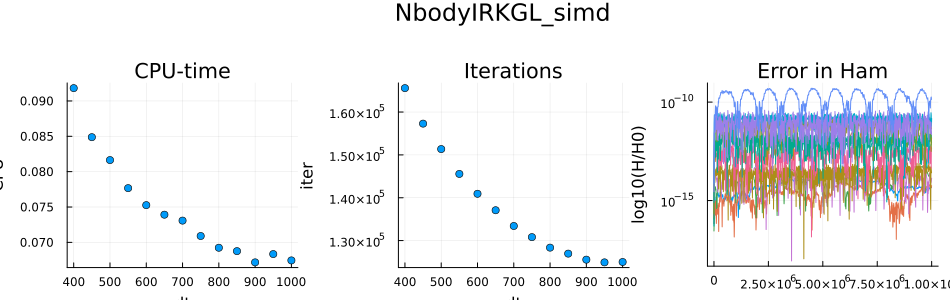

,400.0,450.0,500.0,550.0,600.0,650.0,700.0,750.0,800.0,850.0,900.0,950.0,1000.0

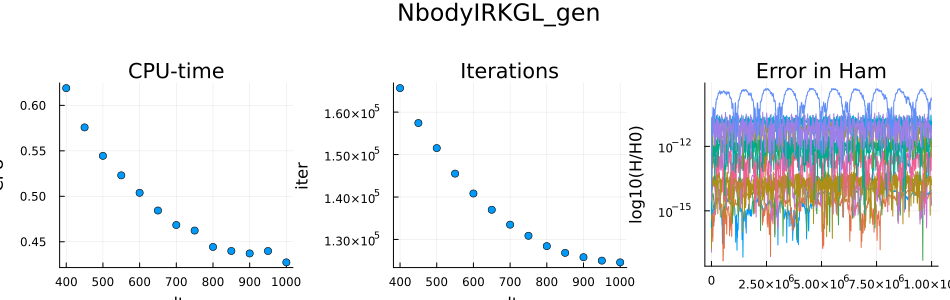

In [10]:
HAM=NbodyEnergy
@show(HAM(u0,Gm))

ddt0=collect(400.:50:1000)
#ddt0=[100.]
 
sols_simd,retcodes_simd,iters_simd,cpus_simd,MaxΔHglobal_simd,MaxΔHlocal_simd=
run_many_NbodyIRKGL(ddt0, tspan, u0, Gm, HAM; simdB=true, adaptiveB=false)
fig=plots_NbodyIRKGL("NbodyIRKGL_simd",ddt0,u0, Gm,HAM,sols_simd,iters_simd,cpus_simd,MaxΔHlocal_simd)
display(fig)
#
sols_gen,retcodes_gen,iters_gen,cpus_gen, MaxΔHglobal_gen, MaxΔHlocal_gen=
run_many_NbodyIRKGL(ddt0, tspan, u0, Gm, HAM; simdB=false, adaptiveB=false)
fig=plots_NbodyIRKGL("NbodyIRKGL_gen",ddt0,u0, Gm, HAM,sols_gen,iters_gen,cpus_gen,MaxΔHlocal_gen)
display(fig)

# Work-precision diagrams

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194


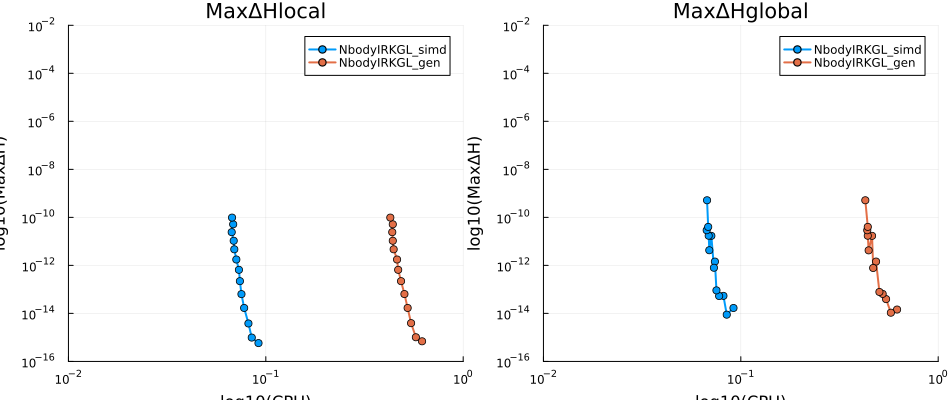

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194


In [11]:
yrange=(1e-16, 1e-2)
xrange=(1e-2,1e0)
pl1=plot( cpus_simd , MaxΔHlocal_simd, scale=:log10,
          markershape=:circle, lw=2,
          ylimits=yrange, xlimits=xrange,
          title="MaxΔHlocal", xlabel="log10(CPU)", ylabel="log10(MaxΔH)", label="NbodyIRKGL_simd")
plot!(pl1, cpus_gen , MaxΔHlocal_gen, 
      markershape=:circle, lw=2,
      scale=:log10, xlabel="log10(CPU)", ylabel="log10(MaxΔH)", label="NbodyIRKGL_gen")


pl2=plot( cpus_simd , MaxΔHglobal_simd, scale=:log10,
         markershape=:circle, lw=2,
         ylimits=yrange, xlimits=xrange,
         title="MaxΔHglobal", xlabel="log10(CPU)", ylabel="log10(MaxΔH)", label="NbodyIRKGL_simd")

plot!(pl2, cpus_gen , MaxΔHglobal_gen,
     markershape=:circle, lw=2,
           scale=:log10, xlabel="log10(CPU)", ylabel="log10(MaxΔH)", label="NbodyIRKGL_gen")

plot(pl1,pl2, layout=(1,2), size=(950,400)) #plot_title="", plot_titlevspan=0.2)